In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report,  precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  Input, Dropout, Conv2D, MaxPooling2D, Flatten

from pytorch_tabnet.tab_model import TabNetClassifier
import torch



In [27]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

In [3]:
df = pd.read_excel('df.xlsx')
print("Dimensions of the dataset:", df.shape)

nas_per_column = df.isna().sum()
columns_with_nas = nas_per_column[nas_per_column > 0]
print("\nColumns with missing values and their counts:")
print(columns_with_nas)

# to predict: without_formal_contract, envelope_wage, dep_self_empl, has_OR_would_have_undeclared_salary
#print("\nNames of columns:", df.columns.tolist())
columns_to_drop = ['without_formal_contract', 'envelope_wage', 'dep_self_empl', 'has_OR_would_have_undeclared_salary']

# Separate features and target
X = df.drop(columns=columns_to_drop, axis=1)
y = df['dep_self_empl']

# Class imbalance
print('\nClass imbalance for dep_self_empl :\n', df['dep_self_empl'].value_counts())

Dimensions of the dataset: (27565, 130)

Columns with missing values and their counts:
Series([], dtype: int64)

Class imbalance for dep_self_empl :
 0    27504
1       61
Name: dep_self_empl, dtype: int64


# Class Balance: Undersample

In [34]:
# Define the undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# Resample the data
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of the resampled dataset:", X_resampled.shape)
print("Dimensions of train:", X_train.shape)
print("Dimensions of test:", X_test.shape)
print('\nClass balance for without_formal_contract :\n', y_resampled.value_counts())

Dimensions of the resampled dataset: (122, 126)
Dimensions of train: (97, 126)
Dimensions of test: (25, 126)

Class balance for without_formal_contract :
 0    61
1    61
Name: dep_self_empl, dtype: int64


# 1. Random Forest

Training Set Accuracy: 1.0000
Test Set Accuracy: 0.8000
Confusion Matrix:
[[11  4]
 [ 1  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.69      0.90      0.78        10

    accuracy                           0.80        25
   macro avg       0.80      0.82      0.80        25
weighted avg       0.83      0.80      0.80        25



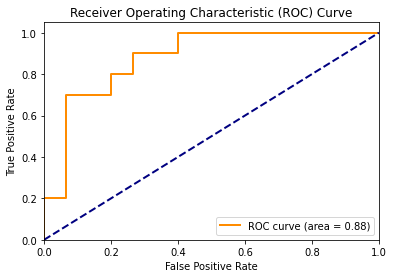

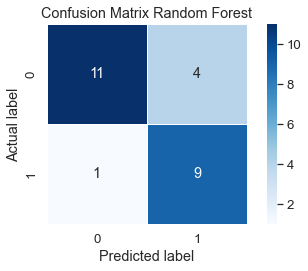

In [5]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Set the best parameters
best_params = {'max_depth':10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Train the model
best_rf.fit(X_train, y_train)

# Predict and evaluate on the training set
y_train_pred = best_rf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Set Accuracy: {training_accuracy:.4f}")

# Predict and evaluate on the test set
y_pred_RF = best_rf.predict(X_test) 
test_accuracy = accuracy_score(y_test, y_pred_RF)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_RF)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_RF))

# ROC Curve using predicted probabilities
y_pred_proba_RF = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_RF)
roc_auc_RF = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix Random Forest')

# Adjust layout
plt.tight_layout()
plt.show()

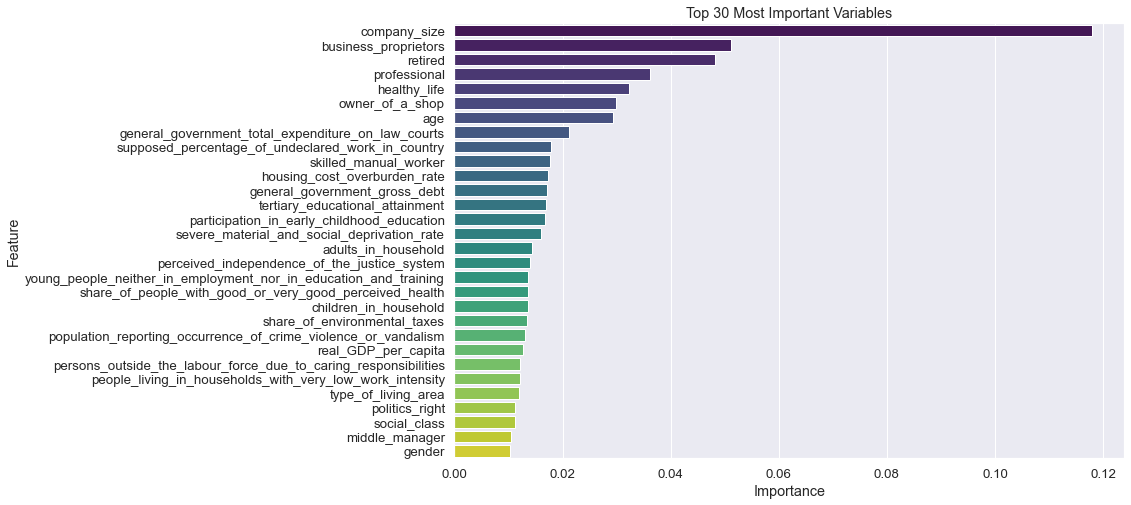

In [6]:

# Importance of variables
importances = best_rf.feature_importances_

# Get indices of top 30 features in descending order
top_indices = importances.argsort()[-30:][::-1]

# Get feature names
feature_names = X.columns

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': [feature_names[i] for i in top_indices], 'Importance': importances[top_indices]})

# Plot the importance of top 30 variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()

# SHAP

In [13]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for class 1
shap_values = explainer.shap_values( X_train)[:, :, 1] #impact on class 1

# Calculate mean SHAP values for each feature
mean_shap_values = shap_values.mean(axis=0)

# Get feature names
feature_names = X_test.columns

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values]

# Display the DataFrame
print(importance_df)

                             Feature  SHAP Value    Impact
0                                age    0.000853  Positive
1                            Belgium    0.000040  Positive
2                            Denmark    0.000000  Negative
3                            Germany   -0.000031  Negative
4                             Greece    0.000096  Positive
..                               ...         ...       ...
121     corruption_Perceptions_Index   -0.000905  Negative
122    confidence_in_EU_institutions    0.000344  Positive
123  official_development_assistance    0.000879  Positive
124     share_of_environmental_taxes   -0.000943  Negative
125    general_government_gross_debt   -0.000237  Negative

[126 rows x 3 columns]


In [16]:
importance_df.to_csv('importance_shap_RF_train_dep_self_empl.csv', index=False)

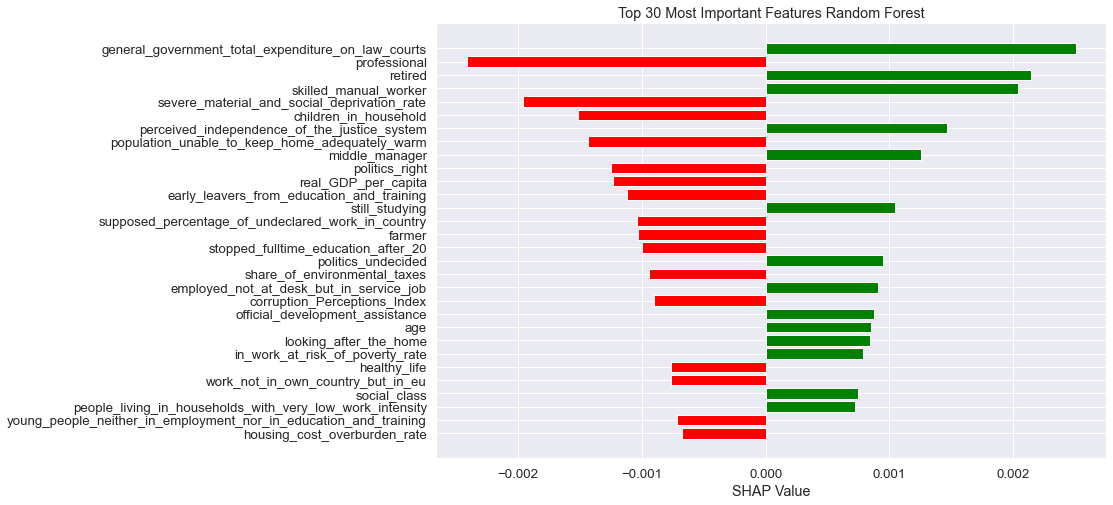

In [17]:
import matplotlib.pyplot as plt

# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()


# 2. MLP Neural Network

In [18]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model final MLP

In [19]:
#2.0	[126, 8]	['relu', 'relu']	binary_crossentropy 	SGD	

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import shap
import pandas as pd

# Set seeds for reproducibility
np.random.seed(140)
tf.keras.utils.set_random_seed(44)
tf.random.set_seed(134)

# Initialize the model
model_MLP = Sequential(name='MLP')

# Add layers directly with numbers
model_MLP.add(Dense(126, activation='relu', input_shape=(126,)))
model_MLP.add(Dense(126, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(8, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(1, activation='sigmoid'))

# Compile the model
model_MLP.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fit the model
model_MLP.fit(X_train, y_train, epochs=5, batch_size=1, verbose=0)



C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# SHAP

In [20]:
explainer_MLP = shap.KernelExplainer(model_MLP.predict,X_train)
shap_values_MLP = explainer_MLP.shap_values(X_train)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  0%|          | 0/97 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 669us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 674us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 685us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 679us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 680us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 685us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 678us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 682us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 677us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 671us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 674us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6924/6924 ━━━━━━━━━━━━━━━━━━━━ 5s 669us/step
1/1 ━

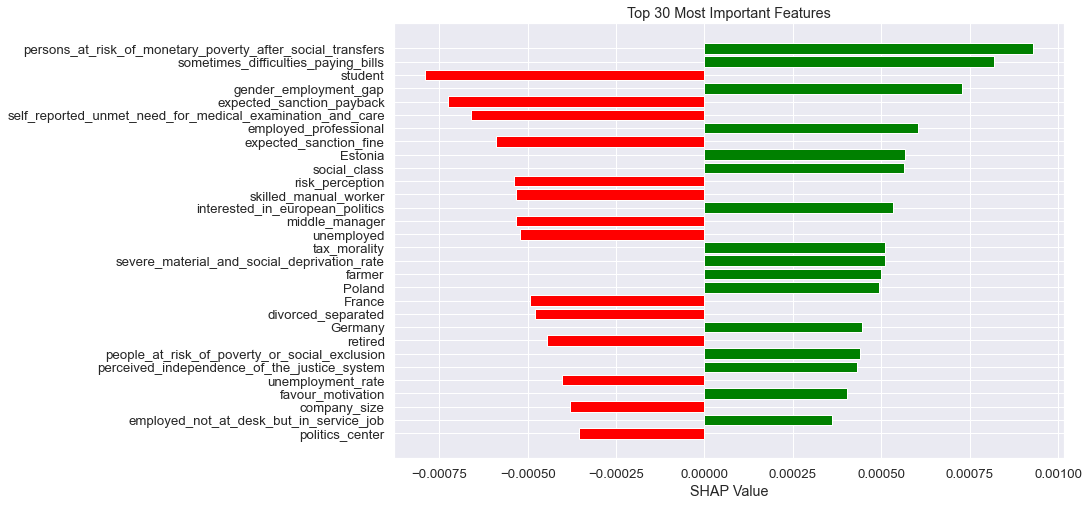

In [21]:
# Calculate mean SHAP values for each feature
mean_shap_values = shap_values_MLP.mean(axis=0).mean(axis=1)

# Get feature names
feature_names = X.columns.to_numpy()

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values]

import matplotlib.pyplot as plt

# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [23]:
importance_df.to_csv('importance_shap_MLP_100test_dep_self_empl.csv', index=False)

## GRAFIC FARA TARI

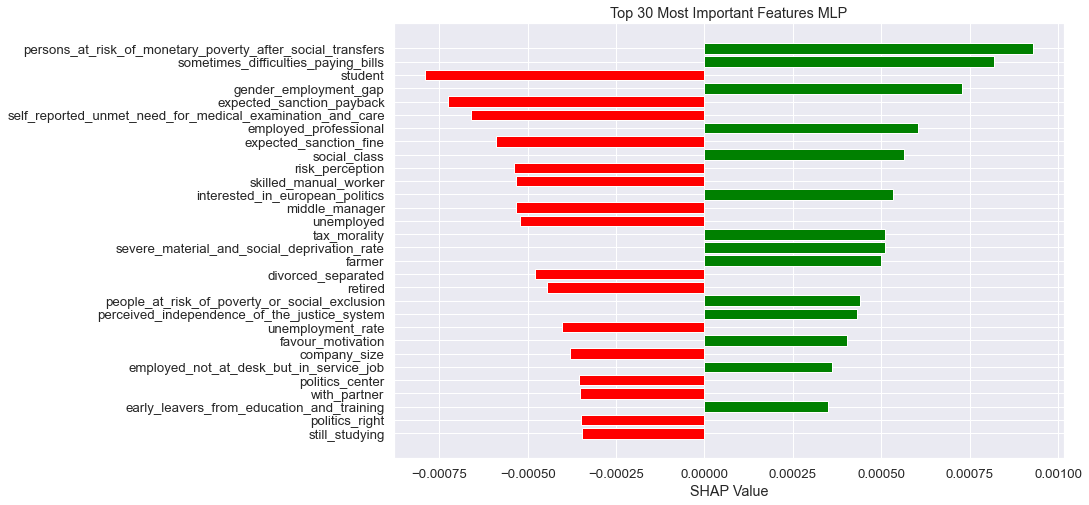

In [25]:
# FARA TARI
importance_df = pd.read_csv('importance_shap_MLP_100test_dep_self_empl.csv')
importance_df= importance_df.drop(df.index[1:30])   #cut out countries


# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features MLP')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

# 3. Tab Net with CV

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Ensure reproducibility
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert pandas DataFrame to numpy array
X_train_array = X_train.values
X_test_array = X_test.values

# Initialize the TabNetClassifier with the best parameters
tabnet_model = TabNetClassifier(
    gamma=2.0,
    lambda_sparse=0.0,
    mask_type='sparsemax',
    n_a=32,
    n_d=16,
    n_independent=2,
    n_shared=1,
    n_steps=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': 0.02}
)


# Define cross-validation strategy (Stratified K-Fold with 5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Fit the model to the entire training data
tabnet_model.fit(X_train_array, y_train)

# Perform cross-validation on training set
cv_scores = cross_val_score(tabnet_model, X_train_array, y_train, cv=skf, scoring='accuracy')
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: {:.2f}".format(cv_scores.mean()))



C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.devi

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

epoch 42 | loss: 0.0     |  0:00:00s
epoch 43 | loss: 0.0     |  0:00:00s
epoch 44 | loss: 0.0     |  0:00:00s
epoch 45 | loss: 0.0     |  0:00:00s
epoch 46 | loss: 0.0     |  0:00:00s
epoch 47 | loss: 0.0     |  0:00:00s
epoch 48 | loss: 0.0     |  0:00:00s
epoch 49 | loss: 0.0     |  0:00:00s
epoch 50 | loss: 0.0     |  0:00:00s
epoch 51 | loss: 0.0     |  0:00:00s
epoch 52 | loss: 0.0     |  0:00:00s
epoch 53 | loss: 0.0     |  0:00:00s
epoch 54 | loss: 0.0     |  0:00:00s
epoch 55 | loss: 0.0     |  0:00:00s
epoch 56 | loss: 0.0     |  0:00:00s
epoch 57 | loss: 0.0     |  0:00:00s
epoch 58 | loss: 0.0     |  0:00:00s
epoch 59 | loss: 0.0     |  0:00:00s
epoch 60 | loss: 0.0     |  0:00:00s
epoch 61 | loss: 0.0     |  0:00:00s
epoch 62 | loss: 0.0     |  0:00:00s
epoch 63 | loss: 0.0     |  0:00:00s
epoch 64 | loss: 0.0     |  0:00:00s
epoch 65 | loss: 0.0     |  0:00:00s
epoch 66 | loss: 0.0     |  0:00:00s
epoch 67 | loss: 0.0     |  0:00:00s
epoch 68 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 42 | loss: 0.0     |  0:00:00s
epoch 43 | loss: 0.0     |  0:00:00s
epoch 44 | loss: 0.0     |  0:00:00s
epoch 45 | loss: 0.0     |  0:00:00s
epoch 46 | loss: 0.0     |  0:00:00s
epoch 47 | loss: 0.0     |  0:00:00s
epoch 48 | loss: 0.0     |  0:00:00s
epoch 49 | loss: 0.0     |  0:00:00s
epoch 50 | loss: 0.0     |  0:00:00s
epoch 51 | loss: 0.0     |  0:00:00s
epoch 52 | loss: 0.0     |  0:00:00s
epoch 53 | loss: 0.0     |  0:00:00s
epoch 54 | loss: 0.0     |  0:00:00s
epoch 55 | loss: 0.0     |  0:00:00s
epoch 56 | loss: 0.0     |  0:00:00s
epoch 57 | loss: 0.0     |  0:00:00s
epoch 58 | loss: 0.0     |  0:00:00s
epoch 59 | loss: 0.0     |  0:00:00s
epoch 60 | loss: 0.0     |  0:00:00s
epoch 61 | loss: 0.0     |  0:00:00s
epoch 62 | loss: 0.0     |  0:00:00s
epoch 63 | loss: 0.0     |  0:00:00s
epoch 64 | loss: 0.0     |  0:00:00s
epoch 65 | loss: 0.0     |  0:00:00s
epoch 66 | loss: 0.0     |  0:00:00s
epoch 67 | loss: 0.0     |  0:00:00s
epoch 68 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Top 30 Feature Importances:
                                               Feature  Importance
71                                        company_size    0.011528
110                              gender_employment_gap    0.010677
111  persons_outside_the_labour_force_due_to_caring...    0.008409
66                           better_quality_motivation    0.007901
38                                              farmer    0.007896
64                                low_price_motivation    0.007894
29                                     other_countries    0.007892
91                 sometimes_difficulties_paying_bills    0.007890
86                          without_fulltime_education    0.007881
0                                                  age    0.007881
85                                      still_studying    0.007881
83            stopped_fulltime_education_between_16_19    0.007881
84                 stopped_fulltime_education_after_20    0.007881
89                               c

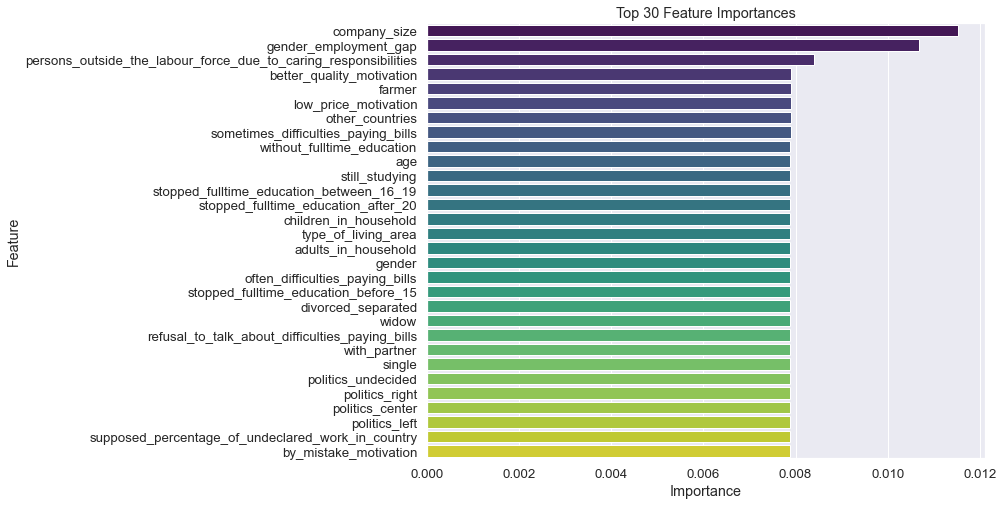

In [38]:
# Calculate feature importance
feature_importances = tabnet_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top 30 most important features
top_30_features = feature_importance_df.head(30)

# Print top 30 feature importance
print("Top 30 Feature Importances:")
print(top_30_features)

# Plot top 30 feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_features, palette='viridis')
plt.title('Top 30 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# SHAP

### Kernel Explainer with train directly (totul da 0)



In [ ]:
import shap

# Initialize the KernelExplainer with the summarized background data
explainer_TabNet= shap.KernelExplainer(tabnet_model.predict, X_train)

# Calculate SHAP values using the KernelExplainer
shap_values_TabNet = explainer_TabNet.shap_values(X_train)

In [ ]:
# Calculate mean SHAP values across the samples
mean_shap_values = shap_values_TabNet.mean(axis=0)

# Get feature names
feature_names = X.columns.to_numpy()

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values]

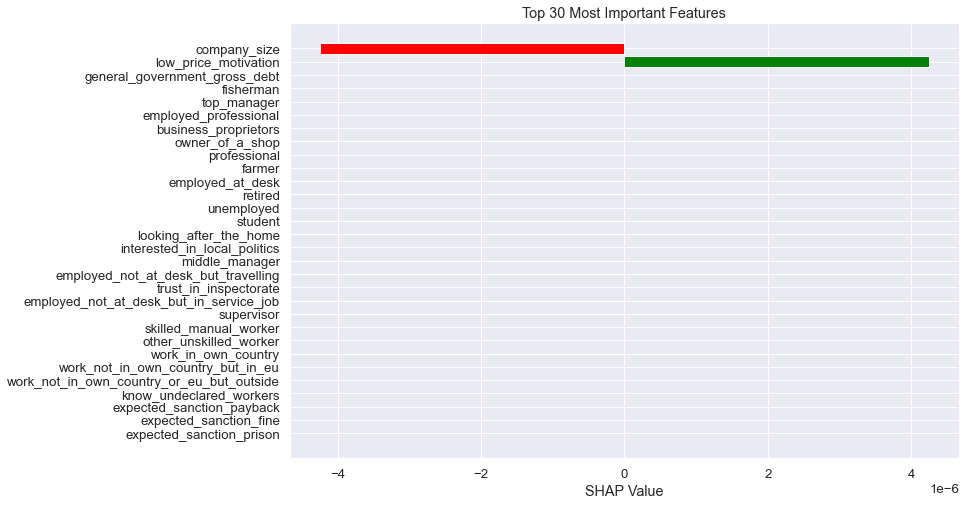

In [44]:

import matplotlib.pyplot as plt

# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [39]:
importance_df.to_csv('1importance_shap_TabNet_train_dep_self_empl.csv', index=False)
#importance_df = pd.read_csv('1importance_shap_TabNet_train_dep_self_empl.csv')

### Explainer

In [70]:

# Convert the model to a scikit-learn compatible format
class TabNetWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, X):
        return self.model.predict_proba(X.values)

# Create a wrapper for TabNet model
tabnet_wrapper = TabNetWrapper(tabnet_model)

# Explain the model predictions using SHAP
explainer = shap.Explainer(tabnet_wrapper.predict_proba, X_train)
shap_values_TabNet = explainer(X_train)


PermutationExplainer explainer: 98it [02:03,  1.39s/it]                                                                


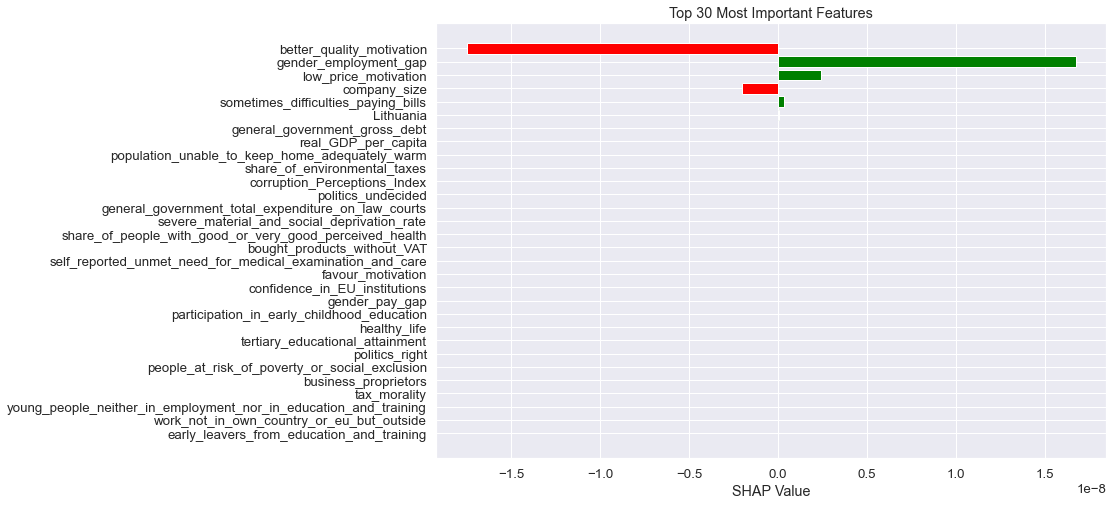

In [71]:

# Get feature names
feature_names = X.columns.tolist()

# Calculate mean SHAP values across the samples
mean_shap_values = shap_values_TabNet.values.mean(axis=0)
mean_shap_values = mean_shap_values[:, 1]

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values]

# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [72]:
importance_df.to_csv('2importance_shap_TabNet_train_dep_self_empl.csv', index=False)

### Kernel Explainer cu array (totul da 0)

In [73]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Convert the model to a scikit-learn compatible format
class TabNetWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, X):
        return self.model.predict_proba(X)


# Create a wrapper for TabNet model
tabnet_wrapper = TabNetWrapper(tabnet_model)

# Explain the model predictions using SHAP with Kernel Explainer
explainer = shap.KernelExplainer(tabnet_wrapper.predict_proba, X_train_array)
shap_values_TabNet = explainer.shap_values(X_train_array)

# Get feature names
feature_names = X_train.columns.tolist()

# Calculate mean SHAP values across the samples
mean_shap_values = shap_values_TabNet.mean(axis=0)


  0%|          | 0/97 [00:00<?, ?it/s]

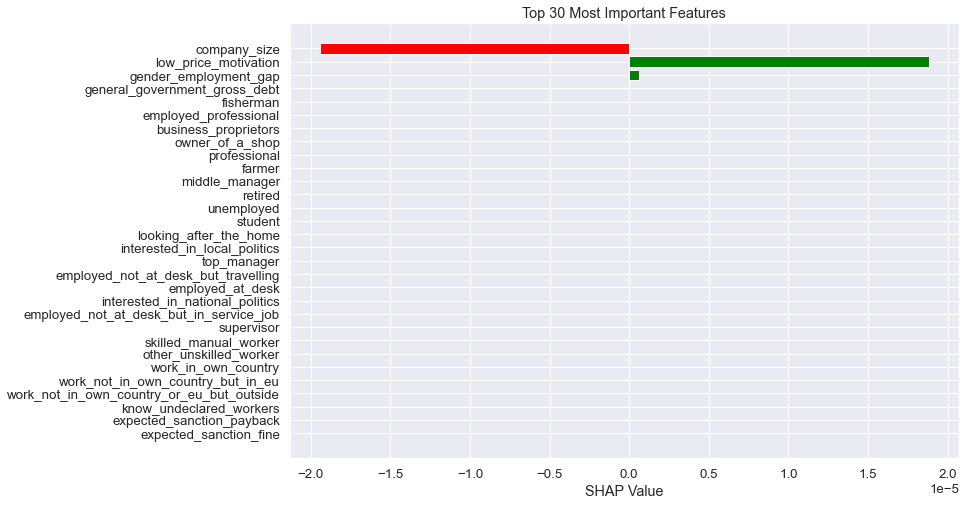

In [74]:
# Get feature names
feature_names = X.columns.tolist()

# Calculate mean SHAP values across the samples
mean_shap_values = shap_values_TabNet.mean(axis=0)
shap_values_class_1 = mean_shap_values[:, 1]

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': shap_values_class_1})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in shap_values_class_1]

# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()


In [75]:
importance_df.to_csv('importance3_shap_TabNet_train_dep_self_empl.csv', index=False)

# 4. Convolutional Neural Networks

In [76]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#SET SEED
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of X_train:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dimensions of X_train: (97, 126)
Dimensions of X_test: (25, 126)
Dimensions of y_train: (97,)
Dimensions of y_test: (25,)


In [92]:

#Reshape the data into 2D grid-like structure based on the data's dimensions
# Here, we reshape it into a 14x9 grid
X_train_reshaped = X_train_scaled.reshape(-1, 14, 9, 1)
X_test_reshaped = X_test_scaled.reshape(-1, 14, 9, 1)
print("Dimensions of X_train_reshaped:", X_train_reshaped.shape)
print("Dimensions of X_test_reshaped:", X_test_reshaped.shape)


Dimensions of X_train_reshaped: (97, 14, 9, 1)
Dimensions of X_test_reshaped: (25, 14, 9, 1)


## MODEL CNN FINAL 

In [93]:

#------------------------------------------------------------------------------------------------------------------------------

##1.0	1.0	1.0	1.0	[64, 126]	['relu', 'relu']	binary_crossentropy	SGD	
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Define and compile the CNN model
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14, 9, 1)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(126, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_CNN.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
model_CNN.fit(X_train_reshaped, y_train, epochs=5, batch_size=1, shuffle=False, verbose=0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/97 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.007e-02, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 171 iterations, alpha=1.161e-03, previous alpha=1.161e-03, with an active set of 42 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.892e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=8.268e-03, previous alpha=8.268e-03, with an active set of 19 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=3.199e-04, with an active set of 33 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 76 iterations, alpha=1.203e-04, previous alpha=1.203e-04, with an active set of 43 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
304/304 ━━━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.180e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=7.628e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. a

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.261e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 137 iterations, alpha=2.073e-03, previous alpha=2.073e-03, with an active set of 42 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
304/304 ━━━━━━

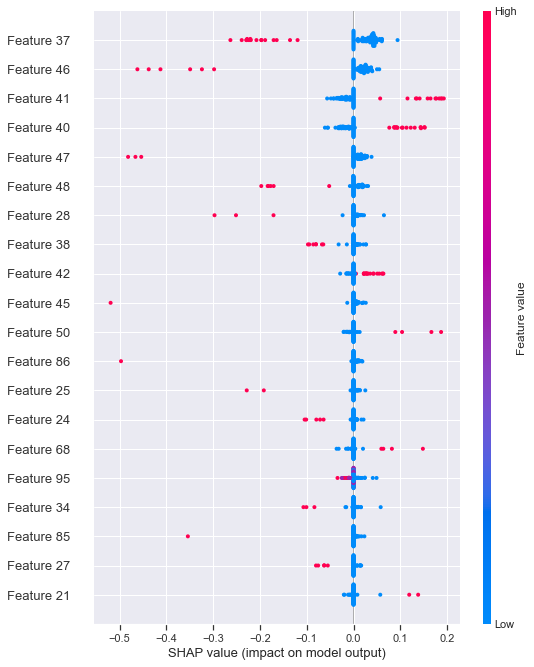

In [95]:
# Define a function to predict with the model and reshape the input
def predict_with_reshape(data):
    reshaped_data = data.reshape(-1, 14, 9, 1)
    return model_CNN.predict(reshaped_data)

# Initialize the KernelExplainer with the training observations reshaped to 2D
explainer_CNN = shap.KernelExplainer(predict_with_reshape, X_train_reshaped.reshape(X_train_reshaped.shape[0], -1))

# Use all observations in the training set
X_train_reshaped_flat = X_train_reshaped.reshape(X_train_reshaped.shape[0], -1)

# Calculate SHAP values using the KernelExplainer
shap_values_CNN = explainer_CNN.shap_values(X_train_reshaped_flat, nsamples=100)

# Reshape SHAP values to original 14x9 features
shap_values_original = np.array(shap_values_CNN).reshape(-1, 14, 9)

# Plot summary plot for the SHAP values
shap.summary_plot(shap_values_original.reshape(shap_values_original.shape[0], -1), X_train_reshaped_flat, feature_names=[f'Feature {i}' for i in range(X_train_reshaped_flat.shape[1])])

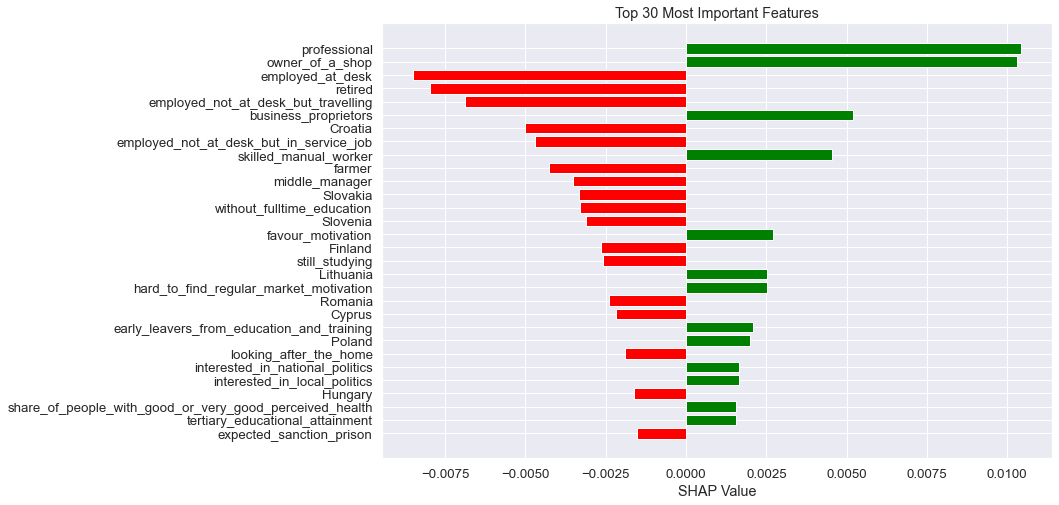

In [96]:
# Calculate mean SHAP values for each feature
mean_shap_values = shap_values_original.mean(axis=0)

# Get feature names (assuming you have feature names in X.columns)
feature_names = X.columns.to_numpy()

# Create a DataFrame to store feature importance and direction
importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Value': mean_shap_values.flatten()})

# Determine if the influence is positive or negative
importance_df['Impact'] = ['Positive' if shap_val > 0 else 'Negative' for shap_val in mean_shap_values.flatten()]


# Get the top 30 most important features
import matplotlib.pyplot as plt
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [97]:
importance_df.to_csv('dep_self_empl_importance_shap_CNN_train.csv', index=False)

# Grafic fara tari

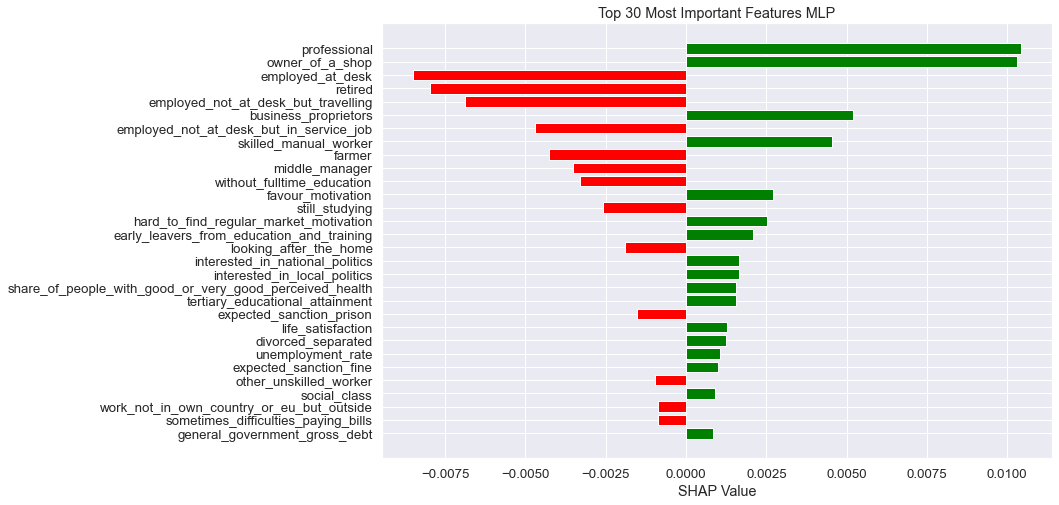

In [98]:
# FARA TARI
importance_df = pd.read_csv('dep_self_empl_importance_shap_CNN_train.csv')
importance_df= importance_df.drop(df.index[1:30])   #cut out countries


# Get the top 30 most important features
top_features = importance_df.iloc[importance_df['SHAP Value'].abs().argsort()[::-1][:30]]

# Plot the bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['SHAP Value'], color=top_features['Impact'].map({'Positive': 'green', 'Negative': 'red'}))
plt.xlabel('SHAP Value')
plt.title('Top 30 Most Important Features MLP')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()